In [17]:
from dowhy import CausalModel

In [18]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

## The Dataset

The dataset used studies Government Transfers and Political Support.

Source: American Economic Journal: Applied Economics, 3(3), pp.1-28.


The dataset contains data on a government transfer program that was administered based on an income cutoff.

Data is limited to households hovering around the income cutoff.

In [19]:
gov_data = pd.read_csv("https://raw.githubusercontent.com/NickCH-K/causaldata/main/Python/causaldata/gov_transfers/Government_Transfers_RDD_Data.csv")

In [20]:
gov_data.head(5)

,Income_Centered,Education,Age,Participation,Support
0,0.006571,3.5,23.666666,0,1.0
1,0.011075,1.5,42.000000,0,1.0
2,0.002424,4.0,43.000000,0,1.0
3,0.007650,6.0,21.000000,0,0.5
4,0.010001,2.0,33.000000,0,1.0


In [21]:
# checking for available data types
gov_data.dtypes

Income_Centered    float64
Education          float64
Age                float64
Participation        int64
Support            float64
dtype: object

The dataset contains 1,948 observations with 5 variables.

The variables in the dataset include:
- Income_Centered: Measure of income, centered around the program cutoff. Negative values indicate Eligibility.
- Education: Household average years of education among those 16 +
- Age: Household Average Age
- Participation: Participation in the Government Transfers Program
- Support: Measure of Support for the Government

##  Approach

**Hypothesis being studied: Do welfare programs targeting the needy translate into more votes (broadly, support for the government) ?**

The following is my identification of the target, control and treatment features:
- TARGET (OUTCOME VARIABLE): Measure of Support for the Government.
- CONTROL FEATURES: Income_Centered, Education, Age
- TREATMENT FEATURES - Participation

In [22]:
# more exploratory analysis
gov_data['Participation'].value_counts()

Participation
1    1127
0     821
Name: count, dtype: int64

In [23]:
# Summary level description of the data

gov_data.describe()

,Income_Centered,Education,Age,Participation,Support
count,1948.000000,1897.000000,1948.000000,1948.000000,1948.000000
mean,-0.001580,4.070623,29.124287,0.578542,0.796201
std,0.011631,1.530783,14.428391,0.493919,0.318164
min,-0.019991,0.000000,6.500000,0.000000,0.000000
25%,-0.011714,3.000000,18.383333,0.000000,0.500000
50%,-0.002796,4.000000,25.666666,1.000000,1.000000
75%,0.008447,5.500000,36.000000,1.000000,1.000000
max,0.019892,6.500000,73.000000,1.000000,1.000000


In [24]:
# Check for missing values by column

missing_counts = gov_data.isna().sum()

In [25]:
missing_counts.sort_values()

Income_Centered     0
Age                 0
Participation       0
Support             0
Education          51
dtype: int64

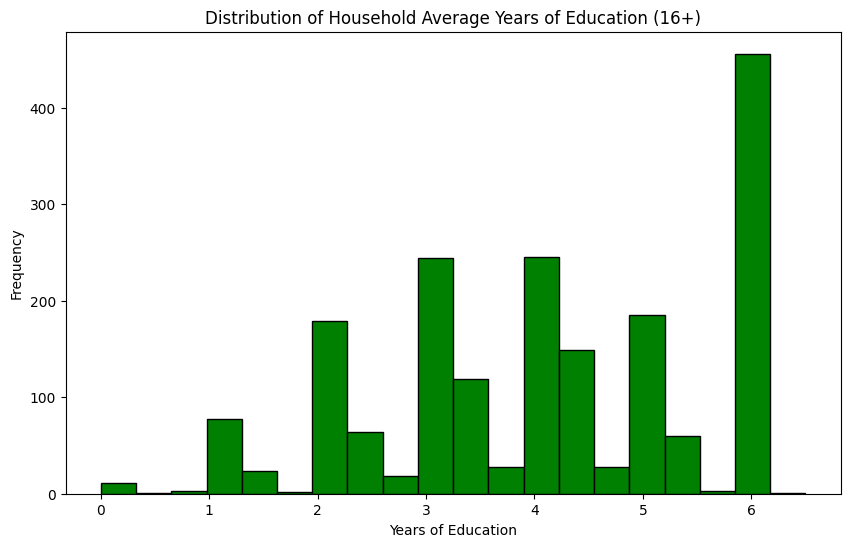

In [26]:
# visualizing the distribution of the education variable

plt.figure(figsize = (10, 6))
plt.hist(gov_data['Education'].dropna(), bins = 20, color = 'green', edgecolor = "black")
plt.title("Distribution of Household Average Years of Education (16+)")
plt.xlabel("Years of Education")
plt.ylabel("Frequency")
plt.show()

In [27]:
# Imputing the missing values for Education with the median

median_education = gov_data['Education'].median()

gov_data['Education'] = gov_data['Education'].fillna(median_education)

In [28]:
gov_data.pivot_table(values = 'Support',
                     index = 'Participation',
                     aggfunc = [np.mean, np.size],
                     margins = True)

/var/folders/z6/mhv044k52r38pf74f9w6gkjc0000gn/T/ipykernel_69621/3242225981.py:1: FutureWarning: The provided callable <function mean at 0x122e9f7e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  gov_data.pivot_table(values = 'Support',


,mean,size
,Support,Support
Participation,,
0,0.727771,821
1,0.846051,1127
All,0.796201,1948


## Creating a Causal Model using dowhy

In [29]:
model = CausalModel(
    data = gov_data,
    treatment = "Participation",
    outcome = "Support",
    common_causes = ["Income_Centered", "Education", "Age"]
)

## view_model()

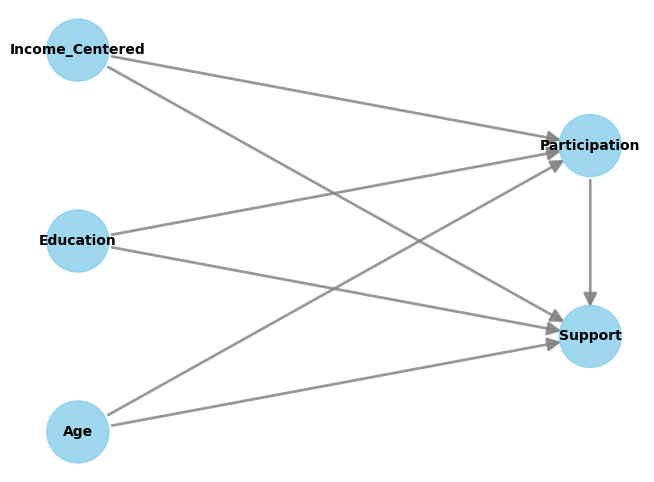

In [30]:
model.view_model()

## identify_effect()

In [21]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable = True)

In [22]:
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                  
────────────────(E[Support|Age,Income_Centered,Education])
d[Participation]                                          
Estimand assumption 1, Unconfoundedness: If U→{Participation} and U→Support then P(Support|Participation,Age,Income_Centered,Education,U) = P(Support|Participation,Age,Income_Centered,Education)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## estimate_effect()

In [23]:
# estimating target estimand using a statistical method

estimate = model.estimate_effect(identified_estimand, method_name = "backdoor.propensity_score_matching")

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                  
────────────────(E[Support|Age,Income_Centered,Education])
d[Participation]                                          
Estimand assumption 1, Unconfoundedness: If U→{Participation} and U→Support then P(Support|Participation,Age,Income_Centered,Education,U) = P(Support|Participation,Age,Income_Centered,Education)

## Realized estimand
b: Support~Participation+Age+Income_Centered+Education
Target units: ate

## Estimate
Mean value: 0.09753593429158111



## Calculating causal effect on the control group with estimate_effect()

In [24]:
# causal effect on the control group

causal_estimate_att = model.estimate_effect(identified_estimand,
                                            method_name = "backdoor.propensity_score_matching",
                                            target_units = "atc")

print(causal_estimate_att)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                  
────────────────(E[Support|Age,Income_Centered,Education])
d[Participation]                                          
Estimand assumption 1, Unconfoundedness: If U→{Participation} and U→Support then P(Support|Participation,Age,Income_Centered,Education,U) = P(Support|Participation,Age,Income_Centered,Education)

## Realized estimand
b: Support~Participation+Age+Income_Centered+Education
Target units: atc

## Estimate
Mean value: 0.10596833130328867



## Interpretation

The average treatment effect of 0.0975 means that,on average, participating in the Government's Transfers program increases the Support by 0.0975 units across the entire population, irrespective of whether they were initially in the treatment or control group. 


The ATC (Average Treatment Effect on the Control Group) of 0.105 means that, on average, the control group would experience an increase of 0.105 units in Support for the Government if they participated in the Transfers program offered by the government.



**This happens to be in alignment with the hypothesis that welfare programs targeting the needy could translate into increased support for the government**